In [1]:
import cv2 as cv
import numpy as np
import os
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import pandas as pd

In [2]:
DATA_DIR = '../data/task%s'

## Task 1:


../data/task1/hands_aligned_train.txt
We only need to keep 33 PCs for 90.0% Energy preservation


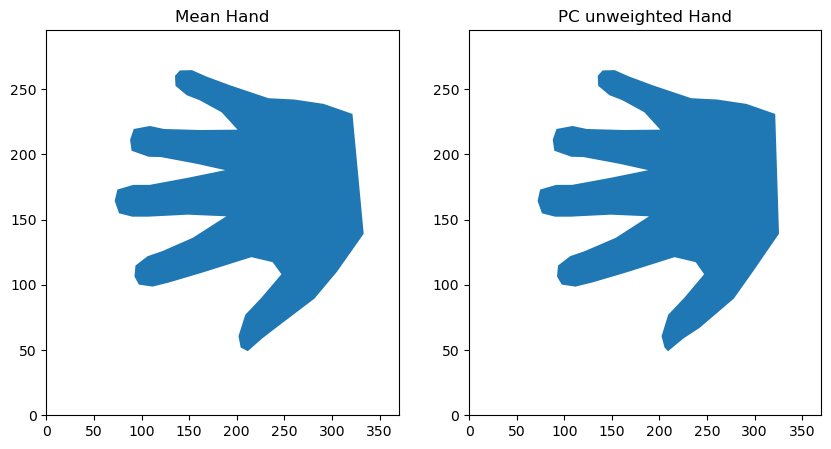

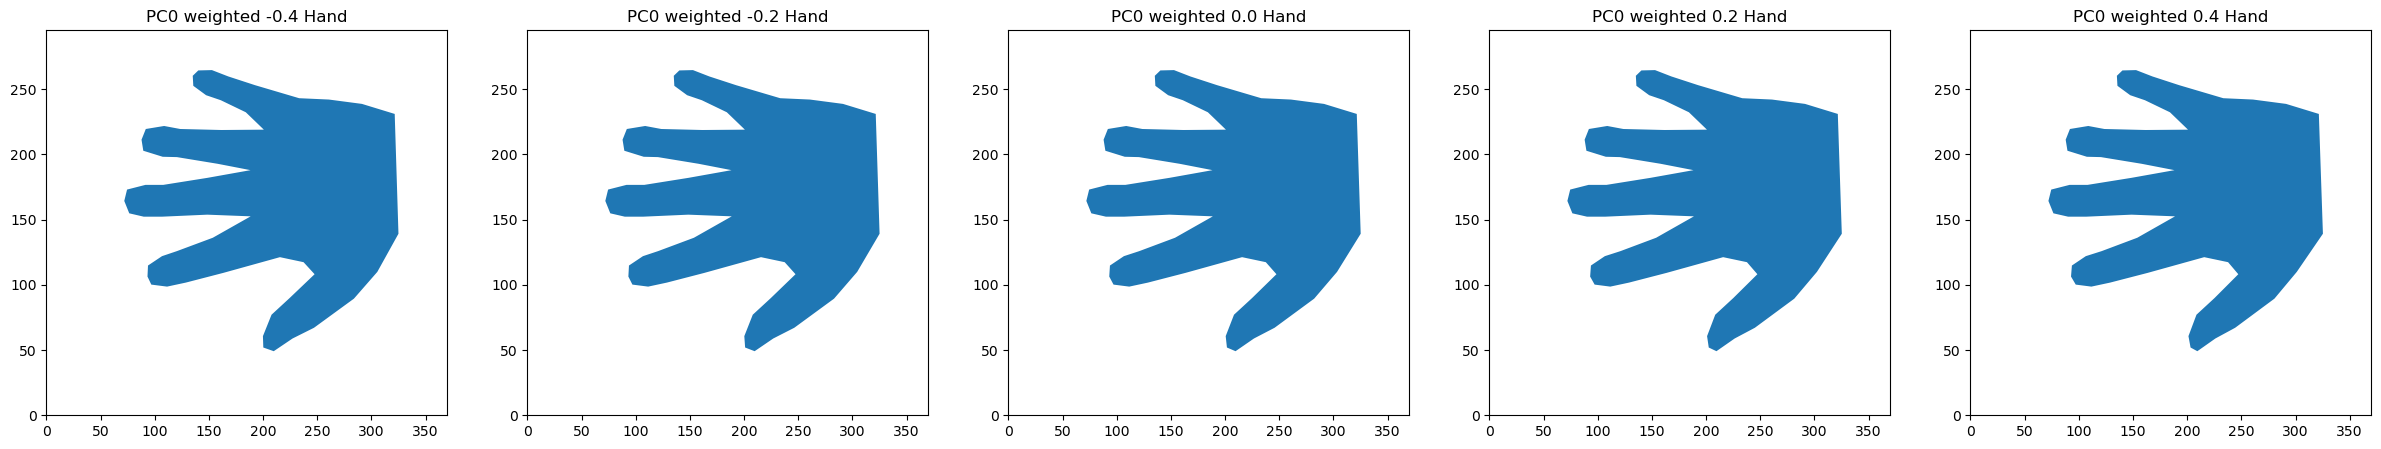

In [3]:
def decomposePCA(dataPoints,  k=None, preservRatio=None):
    # implement PCA for task1 yourself and return the first k 
    # components that preserve preservRatio of the energy and their eigen valuess

    # PCA alg:
    # we want samples in rows and features in cols
    # compute mean of data points w_i and subrtract for every point
    dataPoints = dataPoints.T
    mean = dataPoints.mean(axis=0)
    dataPoints = dataPoints - np.expand_dims(mean, axis=0)

    C = np.cov(dataPoints, rowvar=False)
    # diagonalize C
    l, principal_axes = np.linalg.eig(C)

    # sort eigenvalues in decreasing order
    idx  = l.argsort()[::-1]
    l, principal_axes = l[idx], principal_axes[:, idx]
    principal_components = dataPoints.dot(principal_axes)
    
    # compute the svd
    U, s, Vt = np.linalg.svd(dataPoints, full_matrices=False)
    V = Vt.T
    # for multiplication
    S = np.diag(s)
    # make S the right shape so we can calculate L
    svt = S @ Vt
    svtv = svt @ V
    L_squared = svtv * S
    # now that we have L choose depending on preserveRation until which index
    # we want to keep our principal components
    L_vals = L_squared[L_squared != 0]
    sums = np.cumsum(L_vals)
    energyPreserve = (sums / L_squared.sum())[::-1]
    
    for k, val in enumerate(energyPreserve):
        # if we there is a val which does not fullfill our energyPreserve threshold reduce dimensions
        if val < preservRatio:
            k = k -1
            print(f"We only need to keep {k} PCs for {preservRatio * 100}% Energy preservation")
            pc_reduc = principal_components[:k]
            break
        # if all values preserve energy threshold
        if k == len(energyPreserve)-1:
            k = k + 1
            print("All values are above 90% energy preservation")
            pc_reduc = principal_components
    
    # for our model we want to visualize the mean, and reduced pc components
    return mean, pc_reduc
   


def loadData(filename, skiprows=1):
    #return the data points
    return np.loadtxt(filename, skiprows=skiprows)


def visualizeHands(ax, kpts, title, xlim, ylim):
    #use matplotlib for that
    x = kpts[:56, None]
    y = kpts[56:, None]
    xy = np.concatenate((x,y), axis=1)
    polygon = Polygon(xy)
    ax.add_patch(polygon)
    ax.set_title(title)
    ax.set_xlim(0, xlim)
    ax.set_ylim(0, ylim)


# task 1: training the statistical shape model
# return the trained model so you can use it in task 2
def task1(train_file='hands_aligned_train.txt'):

    trainfilePath = os.path.join(DATA_DIR%'1', train_file)
    print(trainfilePath)
    # train data of shape 112 x 39, where each row is a training data
    # first 56 of the 112 rows are x coords and the last 56 are y coords
    train = loadData(trainfilePath)
    xmax = train[:56].max()
    ymax = train[56:].max()
    
    mean, principle_components = decomposePCA(train, preservRatio=0.9)
    # visualize the mean
    _, ax = plt.subplots(1, 2, figsize=(10,5))
    visualizeHands(ax[0], mean, "Mean Hand", xmax, ymax)
    # principle components with reduced dimensionality
    visualizeHands(ax[1], np.real(principle_components.mean(axis=0)) + mean, "PC unweighted Hand", xmax, ymax)
    
    # now visualize weighted
    W = [-0.4, -0.2, 0.0, 0.2, 0.4]
    _, ax = plt.subplots(1, len(W), figsize=(30, 5))
    for i, w in enumerate(W):
        pc_weighted = np.real(principle_components).copy()
        pc_weighted[:20] = pc_weighted[:20] * w
        visualizeHands(ax[i], pc_weighted.mean(axis=0) + mean, f"PC0 weighted {w} Hand", xmax, ymax)
    return np.real(principle_components), mean
    
pc, mean = task1()

Mean Hand and PC unweighted Hand show differences in thumb.
Every other weighted hand shows close to no difference. Maybe weighting 1 PCA is not enough or the weights are too small.

## Task 2:

../data/task1/hands_aligned_test.txt
(33, 112)
264.4871794871795
(112,)


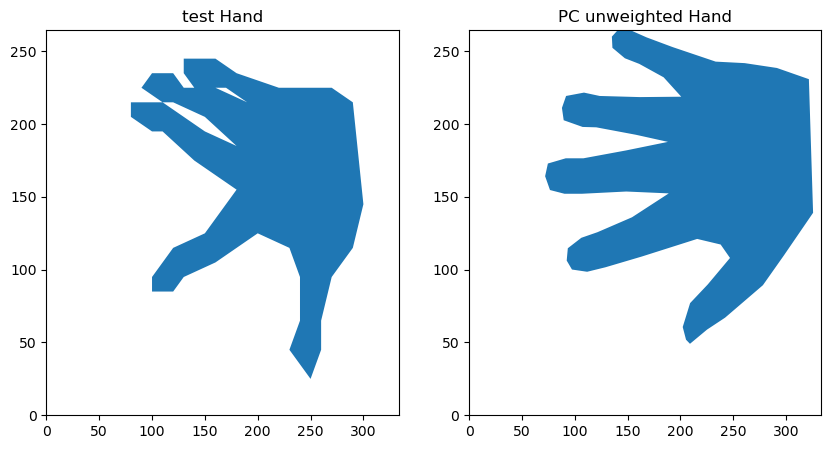

In [4]:
def icp():
    pass


#task2: performing inference on the test hand data using the trained shape model
def task2(shapeModel, mean, test_file='hands_aligned_test.txt'):
    testfilePath = os.path.join(DATA_DIR%'1', test_file)
    print(testfilePath)
    print(shapeModel.shape)
    xmax = np.max(mean[:56])
    ymax = np.max(mean[56:])
    print(ymax)
    test = loadData(testfilePath, skiprows=1)
    print(test.shape)
    _, ax = plt.subplots(1, 2, figsize=(10,5))
    visualizeHands(ax[0], test, "test Hand", xmax, ymax)
    # principle components with reduced dimensionality
    visualizeHands(ax[1], np.real(shapeModel.mean(axis=0)) + mean, "PC unweighted Hand", xmax, ymax)

task2(pc, mean)

In [5]:
def load_face_dataset(datapath="../data/sklearndataset"):
    #load dataset class lfw
    if os.path.exists(datapath) == False:
        os.mkdir(datapath)
    dataset = fetch_lfw_people(data_home=datapath)
    print("Dataset image shape is:", dataset.images.shape)
    dims = [dataset.images.shape[1], dataset.images.shape[2]]
    # create split 80% train 20% test
    X_train, X_test, y_train, y_test = train_test_split(
        dataset.data, dataset.target, test_size=0.2, shuffle=True)
    return X_train, X_test, y_train, y_test, dims

def load_face(dims, datapath_face="../data/task3/detect/face", datapath_notface="../data/task3/detect/notFace"):

    faces = []
    non_faces= []
    # load faces
    for file in os.listdir(datapath_face):
        face = cv.imread(datapath_face + "/" + file, cv.IMREAD_GRAYSCALE)
        # flip dimensions because of cv behaviour
        face = cv.resize(face, dims[::-1])
        faces.append(face)
    # load non faces
    for file in os.listdir(datapath_notface):
        non_face = cv.imread(datapath_notface + "/" + file, cv.IMREAD_GRAYSCALE)
        # flip dimensions because of cv behaviour
        non_face = cv.resize(non_face, dims[::-1])
        non_faces.append(non_face)
    
    
    print(f"Len of faces: {len(faces)}, and len of non faces: {len(non_faces)}")
    return faces, non_faces

def plot_faces(components, num=10):
    _, ax = plt.subplots(2, 5, figsize=(10,5))

    for i, c in enumerate(components[:num]):
        ax[i // 5][i % 5].imshow(c, cmap="gray")
        ax[i // 5][i % 5].set_yticks([])
        ax[i // 5][i % 5].set_xticks([])

In [6]:
X_train, X_test, y_train, y_test, dims = load_face_dataset()
faces, non_faces = load_face(dims)

Dataset image shape is: (13233, 62, 47)
Len of faces: 68, and len of non faces: 5


We have a mean reconstruction error for faces of:  20.41
We have a mean reconstruction error for non_faces of:  16.38
Accuracy of PCA classifier with RMSE:  0.9315068493150684
With NN CLF we have an accuracy of:  0.056667925953910084


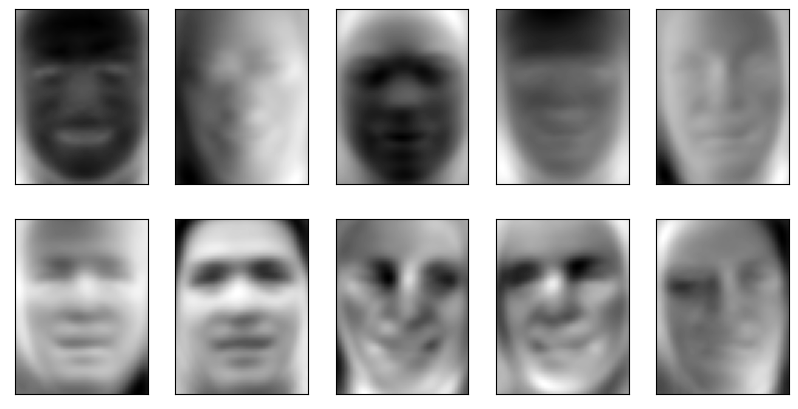

In [7]:
def reconstruction_MSE(recon_img, orig_img):
    assert recon_img.dtype != np.uint8, "Type UIN8 invalid"
    assert orig_img.dtype != np.uint8, "Type UIN8 invalid"
    diff = (recon_img - orig_img)
    rmse = np.sqrt(diff**2)
    return rmse

#eigen faces
def task3(X_train, X_test, y_train, y_test, dims, faces, non_faces):
    #(a)you can use scikit PCA for the decomposition and the dataset class for loading LFW dataset directly
    # train over LFW training split that you created

    # use components = 100 like mentioned in a)
    k = 100
    pca = PCA(n_components=k)
    pca.fit(X_train)
    # image is flattened apparently, reshape to original size
    components = pca.components_.reshape(k, *dims)
    plot_faces(components)

    # average reconstruction error of images:
    # transfrom and inverse transform
    error_faces = []
    for img in faces:
        # reshape images for transform
        transformed = pca.transform(img.reshape(1, -1))
        # reshape the inverse back
        inv_transf = pca.inverse_transform(transformed).reshape(62, 47)
        rmse = reconstruction_MSE(inv_transf, img.astype(np.float64))
        error_faces.append(rmse)
    error_faces = np.array(error_faces)
    print("We have a mean reconstruction error for faces of: ", np.round(error_faces.mean(), decimals=2))
    #(b) evaluate over the samples in data/task3/detect/face and data/task3/detect/notFace

    # calculate RMSE for non faces:
    error_non_faces = []
    for img in non_faces:
        # reshape images for transform
        transformed = pca.transform(img.reshape(1, -1))
        # reshape the inverse back
        inv_transf = pca.inverse_transform(transformed).reshape(62, 47)
        rmse = reconstruction_MSE(inv_transf, img.astype(np.float64))
        error_non_faces.append(rmse)
    error_non_faces = np.array(error_non_faces)
    print("We have a mean reconstruction error for non_faces of: ", np.round(error_non_faces.mean(), decimals=2))
    
    # calculate the accuracy, set rmse detector value between both single rsme of non faces and faces
    rmse_detector_value = (error_faces.mean() + error_non_faces.mean())/2

    hits = 0
    for img in faces:
        # reshape images for transform
        transformed = pca.transform(img.reshape(1, -1))
        # reshape the inverse back
        inv_transf = pca.inverse_transform(transformed).reshape(62, 47)
        rmse = reconstruction_MSE(inv_transf, img.astype(np.float64))
        if rmse.mean() > rmse_detector_value:
            hits +=1

    for img in faces:
        # reshape images for transform
        transformed = pca.transform(img.reshape(1, -1))
        # reshape the inverse back
        inv_transf = pca.inverse_transform(transformed).reshape(62, 47)
        rmse = reconstruction_MSE(inv_transf, img.astype(np.float64))
        if rmse.mean() < rmse_detector_value:
            hits +=1
    print("Accuracy of PCA classifier with RMSE: ", hits/ (len(faces) + len(non_faces)))
    
    #(c) test over LFW test split and calculate the accuracy of recognition
    nn_clf = KNeighborsClassifier()
    # learn on the pc of X_train and y_train
    pc_train = pca.transform(X_train)
    # train nn classifier
    nn_clf.fit(pc_train, y_train)
    # transform X_test in pc
    pc_test = pca.transform(X_test)
    # predict the pc of test
    pred_y_test = nn_clf.predict(pc_test)

    # check for hits to compute accuracy
    hits = 0
    for pred, true in zip(pred_y_test, y_test):
        if pred == true: 
            hits +=1
    print("With NN CLF we have an accuracy of: ", hits/len(y_test))


task3(X_train, X_test, y_train, y_test, dims, faces, non_faces)

Remarks: it somehow makes no sense that the animal reconstruction has less of an error than the face reconstruction. Classification is "rigged" since we set the classifier threshhold to our empirically tested results and classify the same pictures.

## Task 4:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


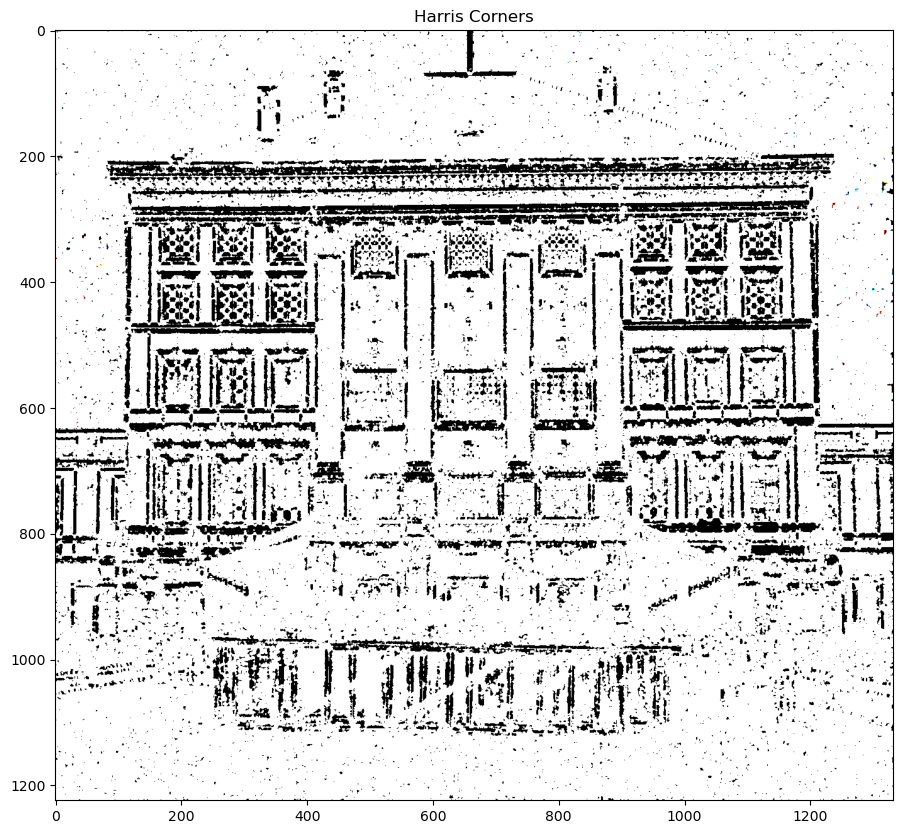

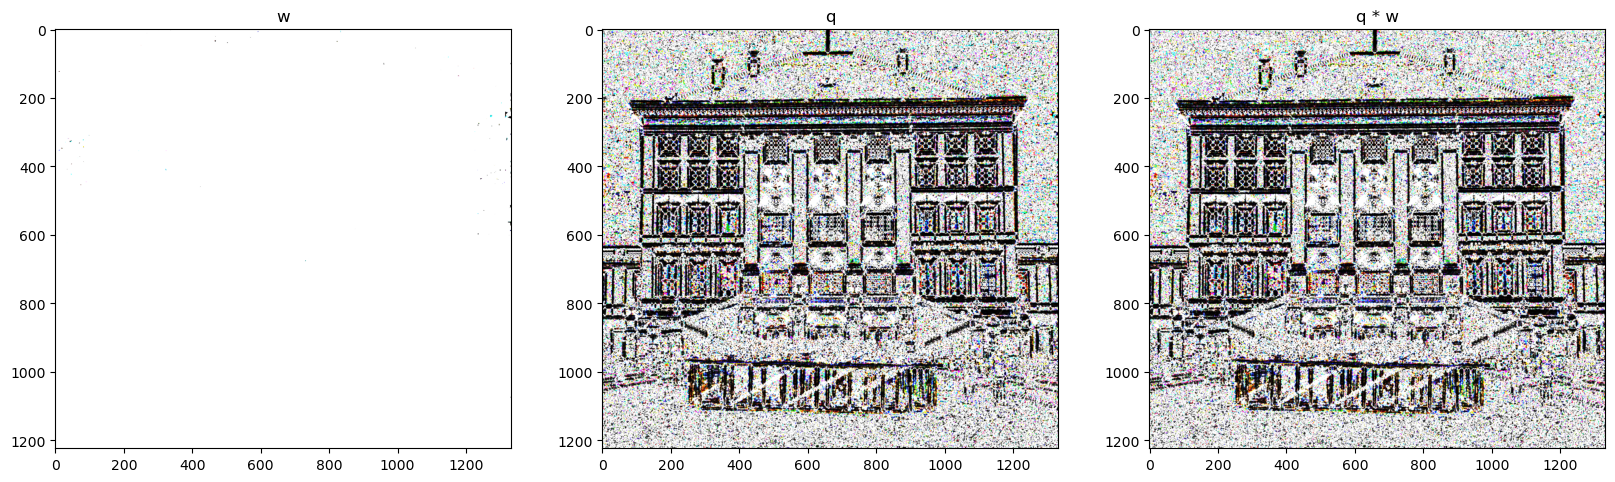

In [8]:
#compute the structural tensor M, you can apply an opencv filters to calculate the gradients
def computeStructural(image):
    M = None
    # with the help of wikipedia it is a weighted convolution over the entries in the matrix [[IxIx, IxIy][IyIx, IyIy]]
    sobelx = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=5)
    sobely = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=5)
    IxIx = np.square(sobelx)
    IyIy = np.square(sobely)
    IxIy = sobelx * sobely
    kernel_size = 3
    weighted_kernel = np.ones((kernel_size, kernel_size)) * ( 1 / kernel_size**2)

    wIxIx = cv.filter2D(IxIx, ddepth=-1, kernel = weighted_kernel)
    wIxIy = cv.filter2D(IxIy, ddepth=-1, kernel = weighted_kernel)
    wIyIx = wIxIy.copy()
    wIyIy = cv.filter2D(IyIy, ddepth=-1, kernel = weighted_kernel)
    # output like the assignment describes it
    M = np.array([[wIxIx, wIxIy],[wIyIx, wIyIy]])
    return M


def detectorCornerHarris(image, M, responseThresh):
    # we have M so far. For harris corner we compute the smallest eigenvalue of the structure tensor
    # for that we approximate det(M) / tr(M)

    # determinant of 2x2 matrix of shape A = [[a, b][c, d]] = ad - b c
    wIxIx = M[0, 0, :, :, :]
    wIxIy = M[1, 0, :, :, :]
    wIyIx = wIxIy.copy()
    wIyIy = M[1, 1, :, :, :]
    det_M = wIxIx * wIyIy + wIxIy * wIyIx
    # trace M is diagonal of the matrix added
    k = 0.04 # from lecture
    ktrace_sq = k * (wIxIx + wIyIy)**2
    # corner response:
    R = det_M - ktrace_sq

    # threshold
    height, width, ch = R.shape
    for c in range(ch):
        mask = R[:, :, c] > responseThresh
        R[mask] = 1

    _, ax = plt.subplots(1, 1, figsize=(20,10))
    ax.imshow(R)
    ax.set_title("Harris Corners")
    

def detectorCornerFoerstner(image, M, responseThresh):
    # similarly to harris corner we compute w and q with determinant and trace
    wIxIx = M[0, 0, :, :, :]
    wIxIy = M[1, 0, :, :, :]
    wIyIx = wIxIy.copy()
    wIyIy = M[1, 1, :, :, :]
    det_M = wIxIx * wIyIy + wIxIy * wIyIx
    trace = wIxIx + wIyIy
    # compute w weight
    w = det_M / (trace + 1e-16)
    # compute q 
    q = 4 * det_M / (trace**2 + 1e-16)

    height, width, ch = w.shape
    for c in range(ch):
        maskw = w[:, :, c] > responseThresh
        w[maskw] = 1
        maskq = q[:, :, c] > responseThresh
        q[maskq] = 1

    _, ax = plt.subplots(1, 3, figsize=(20,10))
    ax[0].imshow(w)
    ax[0].set_title("w")
    ax[1].imshow(q)
    ax[1].set_title("q")
    ax[2].imshow(q * w)
    ax[2].set_title("q * w")


# corner detectors: implement Harris corner detector and Förstner corner  
def task4(imFile ='palace.jpeg'):
    image = cv.imread("../data/task4/palace.jpeg")
    
    #(a)
    M = computeStructural(image)

    responseThresh = 100
    #(b) apply Harris corner detector and visualize
    detectorCornerHarris(image, M, responseThresh)
    #(c) apply Foerstner corner detector and visualise
    detectorCornerFoerstner(image, M, responseThresh)

task4()

W of Foerstner detection seems to be blank at first but artifacts can be detected on the edges of the image, outside of the house.
All in all the FoerstnerCorner results of q seems to be darker overall and more noisy compared to harris corner detection and the inside of windows seem to preserve more "edges", as well as generally overall more edges are detected.


## Task 5:

Image dims:  [491 486]
[200 201 202 203 204 205 206 207 208]


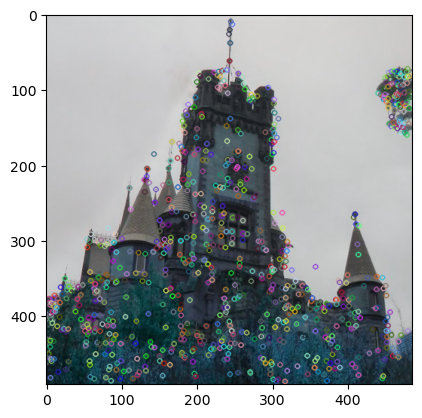

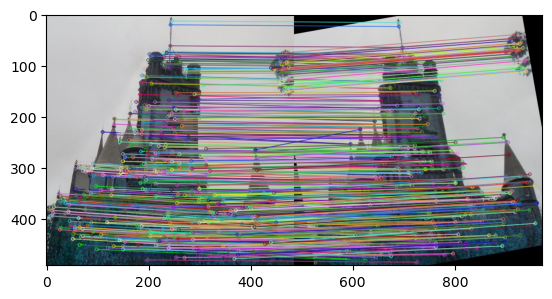

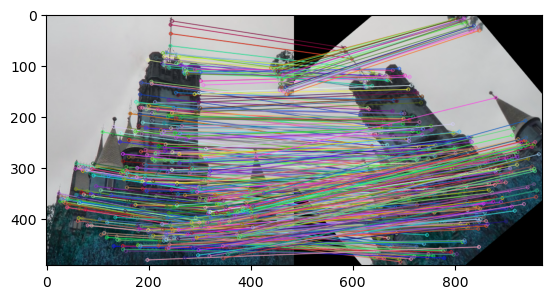

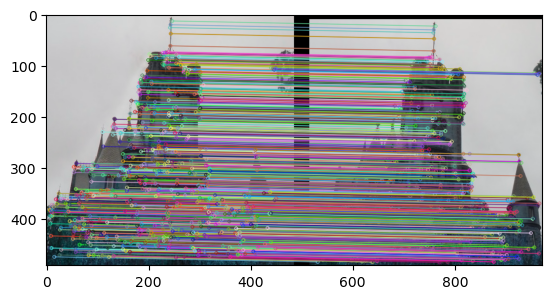

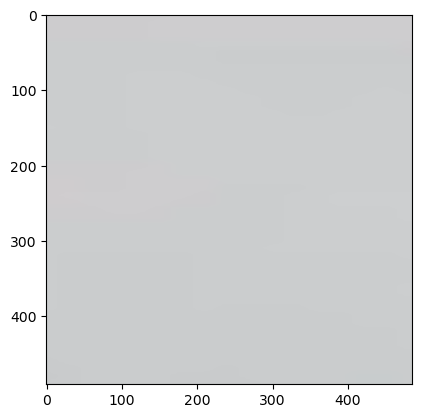

In [42]:
# perform the matching using sift
def match(sift, image1, image2):
    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1, None)
    kp2, des2 = sift.detectAndCompute(image2, None)
    
    # BFMatcher with default params
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    # Apply ratio test
    ratio = 0.5
    good = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good.append([m])

    # cv.drawMatchesKnn expects list of lists as matches.
    img3 = cv.drawMatchesKnn(image1, kp1, image2, kp2, good, None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img3)

def euclid_distance(des1, des2):
    return np.sqrt((des1 - des2)**2)

def rotateImage(image, rotAngle, dims):
    # to get the rotation matrix, you can use cv.getRotationMatrix2D
    rot_mat = cv.getRotationMatrix2D((int(dims[0]//2), int(dims[1]//2)), rotAngle, scale=1 )
    rotatedIm = cv.warpAffine(image, rot_mat, dims[::-1]) #fill in the missing parameters
    return rotatedIm

def translateImage(image, transl, dims):
    # to get the rotation matrix, you can use cv.getRotationMatrix2D
    trans_mat = np.array([
        [1, 0, transl[0]],
        [0, 1, transl[1]]
    ], dtype=np.float32)
    translatedIm = cv.warpAffine(image, trans_mat, dims[::-1]) #fill in the missing parameters
    return translatedIm

def scaleImage(image, scale_fac, dims):
    # to get the rotation matrix, you can use cv.getRotationMatrix2D
    scale_mat = np.array([
        [scale_fac[0], 0, 0],
        [0, scale_fac[1], 0]
    ], dtype=np.float32)
    scaledIm = cv.warpAffine(image, scale_mat, dims[::-1]) #fill in the missing parameters
    return scaledIm

#keypoint matching
def task5(datapath="../data/task5/castle.jpeg"):

    image = cv.imread(datapath)
    #you can use cv's implementation of SIFT
    sift = cv.SIFT_create()
    keypoints = sift.detect(image, None)
    out = None
    out = cv.drawKeypoints(image, keypoints, outImage=out)
    plt.imshow(out)

    dims = np.array([image.shape[0], image.shape[1]])
    print("Image dims: ", dims)
    # apply each of the following transformations and then perform matching
    # Please choose two values of your choice for each one
    rotAngles = [10, 40] # todo choose two values
    for rotAngle in rotAngles:
        rotatedIm = rotateImage(image, rotAngle, dims)
        _, ax = plt.subplots(1,1)
        ax.imshow(rotatedIm)
        match(sift, image, rotatedIm)
        #todo visualise using cv.drawMatches
    
    #do the same with a translation transformation
    translation = [30, 10]
    translatedIm = translateImage(image, translation, dims)
    _, ax = plt.subplots(1,1)
    ax.imshow(translatedIm)
    match(sift, image, translatedIm)
    
    #do the same with a scaling transformation
    scale = [0.1, 0.1]
    scaledIm = scaleImage(image, translation, dims)
    print(np.unique(scaledIm))
    _, ax = plt.subplots(1,1)
    ax.imshow(scaledIm) # does not seem to work for whatever reason
    # match(sift, image, scaledIm)

task5()

Scale as an affine version instead of resize does not seem to work. Since the affine matrix of scale seems reasonable I can't understand why.

In [43]:
class RansacModel:
    pass
# Image homography: implement the RANSAC algorithm then apply it to stitch the two images of Bonn's
# Poppelsdorfer Schloss and then visualise the stitched image
def task6():
    img1 = cv.imread("../data/task6/schloss1.jpeg")
    img2 = cv.imread("../data/task6/schloss2.jpeg")
    

task6()